## 0. Import packages

In [1]:
import pandas as pd
import gzip
import math
from tqdm import tqdm
from itertools import chain, combinations
from Association import Association
from math import sqrt
tqdm.pandas() #for progres_apply etc.

## 1. Load data from previous step

In [2]:
seed_index = 0

In [3]:
import pickle
train_df = pickle.load(open(f"pickle_dumps/train_df_{seed_index}.p", "rb"))
tests_df = pickle.load(open(f"pickle_dumps/test_df_{seed_index}.p", "rb"))

article_train_df = pickle.load(open(f"pickle_dumps/article_train_df_{seed_index}.p", "rb"))
article_test_df = pickle.load(open(f"pickle_dumps/article_test_df_{seed_index}.p", "rb"))

In [4]:
train_df

,item_id,user_id
0,"[3485, 2370, 163, 2188, 2484, 2130, 3197, 413,...",0
1,"[470, 3223, 1912, 4349, 2249, 380, 3860, 1483,...",1
2,"[173, 139, 2088, 2132, 285, 352, 678, 521, 798...",2
3,"[206, 299, 354, 1125, 2196, 2839, 1752, 1410, ...",3
4,"[417, 1897, 4786, 840, 1637, 3957, 926, 505, 4...",4
...,...,...
62965,[0],62965
62966,[80],62966
62967,[23],62967
62968,[11],62968


If we plot a disrtibution of the length per user, we see that most data leans towards a length of 100 items

34.22210576464983


(array([2.4862e+04, 1.4450e+04, 8.5030e+03, 5.1300e+03, 3.2860e+03,
        1.9140e+03, 1.1610e+03, 8.5600e+02, 6.1300e+02, 4.4600e+02,
        3.4300e+02, 2.5200e+02, 2.2000e+02, 1.6400e+02, 1.0200e+02,
        9.5000e+01, 7.8000e+01, 6.0000e+01, 5.3000e+01, 3.9000e+01,
        4.9000e+01, 4.7000e+01, 2.1000e+01, 2.6000e+01, 1.2000e+01,
        2.8000e+01, 1.7000e+01, 1.3000e+01, 6.0000e+00, 1.7000e+01,
        1.2000e+01, 1.0000e+01, 1.4000e+01, 7.0000e+00, 9.0000e+00,
        6.0000e+00, 3.0000e+00, 2.0000e+00, 6.0000e+00, 5.0000e+00,
        2.0000e+00, 2.0000e+00, 6.0000e+00, 8.0000e+00, 3.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([  1.  ,  15.24,  29.48,  43.72,  57.96,  72.2 ,  86.44, 100.68,
        114.92, 129.16, 143.4 , 157.64, 171.88, 186.12, 200.36, 214.6 ,
        228.84, 243.08, 257.32, 271.56, 285.8 , 300.04, 314.28, 328.52,
        342.76, 357.  , 371.24, 385.48, 399.72, 413.96, 428.2 , 442.44,
        456.68, 470.92, 485.16

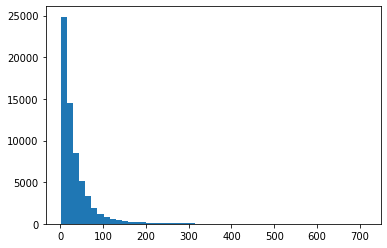

In [5]:
import matplotlib.pyplot as plt
x = [len(i) for i in train_df["item_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [6]:
article_train_df

,item_id,user_id
0,3485,"[0, 1, 4, 8, 10, 11, 43, 54, 58, 70, 133, 176,..."
1,2370,"[0, 2, 4, 5, 9, 16, 31, 67, 71, 78, 128, 145, ..."
2,163,"[0, 2, 4, 5, 8, 9, 11, 16, 17, 18, 19, 22, 23,..."
3,2188,"[0, 3, 4, 6, 8, 11, 13, 21, 25, 35, 39, 49, 52..."
4,2484,"[0, 11, 13, 25, 54, 74, 86, 89, 119, 120, 133,..."
...,...,...
7116,6696,[50173]
7117,7162,[50334]
7118,6679,[51212]
7119,5683,[52319]


The transposed dataframe that is used for building user association rules has only a few items most of the time. this is not that important because of the way user associations are build.

302.62126105884005


(array([6.41e+03, 3.17e+02, 1.30e+02, 7.40e+01, 4.20e+01, 2.60e+01,
        1.40e+01, 1.50e+01, 1.40e+01, 1.30e+01, 1.10e+01, 1.10e+01,
        6.00e+00, 3.00e+00, 2.00e+00, 4.00e+00, 2.00e+00, 2.00e+00,
        6.00e+00, 2.00e+00, 0.00e+00, 3.00e+00, 1.00e+00, 2.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 2.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 2.00e+00]),
 array([1.00000e+00, 5.78100e+02, 1.15520e+03, 1.73230e+03, 2.30940e+03,
        2.88650e+03, 3.46360e+03, 4.04070e+03, 4.61780e+03, 5.19490e+03,
        5.77200e+03, 6.34910e+03, 6.92620e+03, 7.50330e+03, 8.08040e+03,
        8.65750e+03, 9.23460e+03, 9.81170e+03, 1.03888e+04, 1.09659e+04,
        1.15430e+04, 1.21201e+04, 1.26972e+04, 1.32743e+04, 1.38514e+04,
        1.44285e+04, 1.50056e+04, 1.55827e+04, 1.61598e+04, 1

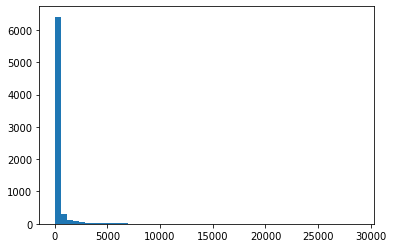

In [7]:
x = [len(i) for i in article_train_df["user_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [8]:
tests_df

,item_id,user_id
0,"[2955, 457, 1430, 2348, 1716, 102, 464, 2417, ...",0
1,"[56, 2486, 573, 1662, 3174, 3132, 292, 4443, 1...",1
2,"[3994, 187, 2602, 4571, 1231, 1620, 1182, 926,...",2
3,"[840, 596, 1148, 890, 815, 1096, 3442, 1660, 8...",3
4,"[980, 1094, 2780, 1095, 3803, 2973, 2052, 981,...",4
...,...,...
62965,[3],62965
62966,[19],62966
62967,[79],62967
62968,[5],62968


In [9]:
data = train_df.set_index("user_id").to_dict()["item_id"]
article_data = article_train_df.set_index("item_id").to_dict()["user_id"]

test_users = tests_df["user_id"].tolist()

## 2. Functions or building association rules

In [10]:
def convertTo(df):
    with open("eclat_in.txt", "w") as f:
        tmp = df.items()
        for item in tmp:
            s = ' '.join([str(elem) for elem in item[1]])
            f.write(s + "\n")
            

def convertFrom():
    res = []
    with open("eclat_out.txt", "r") as f:
        for line in f:
            try:
                tmp = line.strip()
                tmp = tmp.split(" <- ")
                consequent = [tmp[0]]
                tmp = tmp[1].split(" (")
                antecedent = tmp[0].split(" ")
                tmp = tmp[1].strip(')').split(", ")
                sup = tmp[0]
                conf = tmp[1]
                lift = tmp[2]
                z = tmp[3]
                antecedent = list(map(int, antecedent))
                consequent = list(map(int, consequent))
                res.append(Association(antecedent, consequent, float(conf), float(sup), 
                                       float(lift), float(z)))
            except:
                pass
    
    return res

In [11]:
def genRules(min_conf, minsup, df):
    print("---writing data---")
    convertTo(df)
    print("---building rules---")
    !eclat -tr -Z -s-$minsup -c$min_conf -el -v" (%s, %c, %l, %e)" eclat_in.txt eclat_out.txt
    print("---reading data---")
    rules = convertFrom()
    return rules

## 3. Build association rules

### Article association rules
Build rules of the form:
`Item1 and Item2 -> Item3`

In [12]:
%%time

print(len(data))

# Build the article association rules with a minimum support of 50 and minimum confidence of 0.85
raw_article_assos_rules = []
values = [(0,2000), (80,100), (50,333), (25,500)]
for conf,sup in values:
    tmp = genRules(conf, sup, data)
    tmp = sorted(tmp, key=lambda x: x.s * x.c, reverse=True)[:1000000]
    print(len(tmp))
    raw_article_assos_rules.extend(tmp)
    print(len(raw_article_assos_rules))

62970
---writing data---
---building rules---
all: 16327202
  0: 0
  1: 7121
  2: 1234034
  3: 7758026
  4: 6351744
  5: 976277
---reading data---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7121 item(s), 62970 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [7121 item(s)] done [0.00s].
sorting and reducing transactions ... [60790/62970 transaction(s)] done [0.06s].
finding frequent item sets ... done [12.23s].
writing eclat_out.txt ... [16327202 rule(s)] done [6.25s].


1000000
1000000
---writing data---
---building rules---
all: 189722
  0: 0
  1: 0
  2: 0
  3: 102
  4: 4820
  5: 36007
  6: 77569
  7: 56408
  8: 13693
  9: 1109
 10: 14
---reading data---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7121 item(s), 62970 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [2294 item(s)] done [0.00s].
sorting and reducing transactions ... [60752/62970 transaction(s)] done [0.04s].
finding frequent item sets ... done [272.40s].
writing eclat_out.txt ... [189722 rule(s)] done [10.06s].


189722
1189722
---writing data---
---building rules---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7121 item(s), 62970 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [1560 item(s)] done [0.00s].
sorting and reducing transactions ... [60687/62970 transaction(s)] done [0.04s].
finding frequent item sets ... done [38.48s].
writing eclat_out.txt ... [7671745 rule(s)] done [3.46s].


all: 7671745
  0: 0
  1: 0
  2: 5701
  3: 336078
  4: 2134743
  5: 3402532
  6: 1530877
  7: 251782
  8: 9985
  9: 47
---reading data---
1000000
2189722
---writing data---
---building rules---
all: 11909112
  0: 0
  1: 9
  2: 39361
  3: 1133035
  4: 4591999
  5: 4658497
  6: 1374950
  7: 109118
  8: 2143
---reading data---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7121 item(s), 62970 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [1816 item(s)] done [0.00s].
sorting and reducing transactions ... [60718/62970 transaction(s)] done [0.04s].
finding frequent item sets ... done [45.09s].
writing eclat_out.txt ... [11909112 rule(s)] done [5.44s].


1000000
3189722
Wall time: 9min 37s


In [34]:
len(raw_article_assos_rules)

3189722

eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [62970 item(s), 7121 transaction(s)] done [0.15s].
filtering, sorting and recoding items ... [23658 item(s)] done [0.01s].
sorting and reducing transactions ... [6777/7121 transaction(s)] done [0.02s].
finding frequent item sets ... done [261.93s].
writing eclat_out.txt ... [14094732 rule(s)] done [9.16s].


all: 14094732
  0: 0
  1: 0
  2: 386033
  3: 10106598
  4: 2947144
  5: 631375
  6: 23582


In [26]:
article_assos_rules = sorted(raw_article_assos_rules, key=lambda x: x.s * x.c, reverse=True)[:1000000]

In [15]:
%%time

# print number of rules with item 3 in the lhs
counter = 0
for r in article_assos_rules:
    if 3 in r.left:
        counter += 1
counter

Wall time: 500 ms


215011

In [16]:
# print number of rules with a support greater than 150
for r in article_assos_rules:
    if int(r.s) > 10000:
        print(r)

### User association rules
Build rules of the form: `User1 and User2 -> User3`

This builds rules that represent the relation and similarity between users.

In [18]:
%%time
# Build the user association rules with a minimum support and minimum confidence

raw_user_assos_rules = []
values = [(0,500), (25,125), (50,75), (80, 40)]
for conf,sup in values:
    tmp = genRules(conf, sup, article_data)
    tmp = sorted(tmp, key=lambda x: x.s * x.c, reverse=True)
    print(len(tmp))
    raw_user_assos_rules.extend(tmp)
    print(len(raw_user_assos_rules))

---writing data---
---building rules---
^C
---reading data---
0
0
---writing data---
---building rules---
^C
---reading data---
0
0
---writing data---


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\stijn\documents\uantwerpen\ma\project-ai\project-ai\lib\site-packages\IPython\core\magics\execution.py", line 1324, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "C:\Users\stijn\AppData\Local\Temp/ipykernel_3888/4065965513.py", line 3, in genRules
    convertTo(df)
  File "C:\Users\stijn\AppData\Local\Temp/ipykernel_3888/3969461204.py", line 6, in convertTo
    f.write(s + "\n")
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\stijn\documents\uantwerpen\ma\project-ai\project-ai\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\stijn\docu

TypeError: object of type 'NoneType' has no len()

In [13]:
%%time
user_assos_rules = list(filter(lambda x: any([i in test_users for i in x.right]), raw_user_assos_rules))

Wall time: 1min 31s


In [14]:
# print numebr of generated rules
print(len(user_assos_rules))

3000000


See for how much test users we were able to create association rules and how many

In [15]:
%%time

corr = {}
user_d = {}
for r in tqdm(user_assos_rules):
    for user in list(r.right):
        if user in corr:
            corr[user] += 1
            user_d[user].append(r)
        else:
            corr[user] = 1
            user_d[user] = [r]

100%|██████████| 3000000/3000000 [00:03<00:00, 880263.83it/s]

Wall time: 3.54 s


In [16]:
for user in user_d:
    user_d[user] = sorted(user_d[user], key=lambda x: x.s * x.c, reverse=True)[:100000]

In [17]:
print(len(test_users))
print(len(corr))
print(corr)

62970
34037
{110: 24777, 17: 8123, 3: 21104, 2: 20256, 30: 8974, 12: 26045, 5: 22845, 15: 12139, 13: 14946, 18: 18664, 85: 6723, 19: 16856, 169: 25534, 16: 12759, 131: 22206, 44: 4149, 67: 25009, 26: 26092, 0: 11108, 29: 16524, 97: 25579, 161: 23778, 4: 7797, 10: 10766, 205: 25603, 32: 14102, 42: 8346, 38: 11104, 55: 18940, 190: 23670, 28: 11321, 20: 6552, 11: 9365, 221: 23874, 48: 6620, 51: 23453, 47: 8472, 195: 25517, 111: 6909, 136: 7581, 14: 5056, 65: 9066, 33: 7214, 41: 6807, 61: 8806, 130: 25586, 225: 25424, 56: 6115, 77: 7066, 53: 4961, 57: 974, 8: 1460, 34: 5206, 306: 20671, 128: 7694, 113: 22165, 23: 1596, 1: 4258, 96: 6589, 263: 25485, 7: 5612, 87: 6218, 9: 915, 45: 12599, 209: 25098, 81: 7724, 63: 874, 76: 670, 100: 2709, 39: 7511, 24: 1312, 22: 5971, 6: 244, 102: 4318, 93: 20103, 315: 20357, 319: 23558, 101: 6653, 358: 24669, 80: 7248, 125: 4783, 172: 3071, 50: 6925, 137: 1188, 104: 4949, 114: 7121, 178: 5538, 105: 4349, 279: 22403, 121: 3719, 91: 4321, 49: 5103, 59: 5940, 

In [19]:
total = 0
for u in user_d:
    total += len(user_d[u])
total

3000000

## 4. Normalize support / confidence to better use it later

In [24]:
"""
minc = 1
maxc = 0

mins = 9999999999999
maxs = -9999999999999
for a in article_assos_rules:
    if a.c < minc:
        minc = a.c
    if a.c > maxc:
        maxc = a.c
    
    if a.s < mins:
        mins = a.s
    if a.s > maxs:
        maxs = a.s
            
for a in article_assos_rules:
    a.c = (a.c - minc) / (maxc - minc)
    a.s = (a.s - mins) / (maxs - mins)
    # temp score that's just lhs + weighted average of c, s
    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))

"""

# article_assos_rules = sorted(article_assos_rules, key = lambda x: x.score, reverse=True)
# for i in article_assos_rules[:20]:
#     print(i)


"\nminc = 1\nmaxc = 0\n\nmins = 9999999999999\nmaxs = -9999999999999\nfor a in article_assos_rules:\n    if a.c < minc:\n        minc = a.c\n    if a.c > maxc:\n        maxc = a.c\n    \n    if a.s < mins:\n        mins = a.s\n    if a.s > maxs:\n        maxs = a.s\n            \nfor a in article_assos_rules:\n    a.c = (a.c - minc) / (maxc - minc)\n    a.s = (a.s - mins) / (maxs - mins)\n    # temp score that's just lhs + weighted average of c, s\n    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))\n\n"

## 5. Store the association rules as pickle file for further use

In [27]:
import pickle
pickle.dump(article_assos_rules, open("pickle_dumps/article_rules.p", "wb"))
pickle.dump(user_d, open("pickle_dumps/user_rules.p", "wb"))

In [20]:
pickle.dump(user_d, open("pickle_dumps/user_rules.p", "wb"))